# Student Perfomarce Analysis

### Data Pre-processing

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# Load data
student_data = pd.read_csv('Student_performance_10k.csv')
student_data.head(3).T

,0,1,2
roll_no,std-01,std-02,std-03
gender,male,male,male
race_ethnicity,group D,group B,group C
parental_level_of_education,some college,high school,master's degree
lunch,1.0,1.0,1.0
test_preparation_course,1.0,0.0,0.0
math_score,89,65,10
reading_score,38.0,100.0,99.0
writing_score,85.0,67.0,97.0
science_score,26.0,96.0,58.0


In [3]:
student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   roll_no                      9999 non-null   object 
 1   gender                       9982 non-null   object 
 2   race_ethnicity               9977 non-null   object 
 3   parental_level_of_education  9978 non-null   object 
 4   lunch                        9976 non-null   float64
 5   test_preparation_course      9977 non-null   float64
 6   math_score                   9976 non-null   object 
 7   reading_score                9975 non-null   float64
 8   writing_score                9976 non-null   float64
 9   science_score                9977 non-null   float64
 10  total_score                  9981 non-null   float64
 11  grade                        9997 non-null   object 
dtypes: float64(6), object(6)
memory usage: 937.6+ KB


In [4]:
# Obtain number of null values per column
student_data.isna().sum()

roll_no                         1
gender                         18
race_ethnicity                 23
parental_level_of_education    22
lunch                          24
test_preparation_course        23
math_score                     24
reading_score                  25
writing_score                  24
science_score                  23
total_score                    19
grade                           3
dtype: int64

In [5]:
# Drop null values and calculate percentage of dropped data
pre_drop_num_rows = student_data.shape[0]
student_data = student_data.dropna()
post_drop_num_rows = student_data.shape[0]
percentage_dropped = ((pre_drop_num_rows - post_drop_num_rows)/pre_drop_num_rows)*100

print(f'Percentage of dropped data: {percentage_dropped}%')

# Confirm non-null dataset
student_data.isna().sum()

Percentage of dropped data: 2.13%


roll_no                        0
gender                         0
race_ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
math_score                     0
reading_score                  0
writing_score                  0
science_score                  0
total_score                    0
grade                          0
dtype: int64

In [6]:
# Handle data consistency

# Convert lunch and test_preparation_course to categories
student_data['lunch'] = student_data['lunch'].astype('object')
student_data['lunch'] = student_data['lunch'].replace({0: 'No', 1: 'Yes'})

student_data['lunch'] = student_data['lunch'].astype('object')
student_data['test_preparation_course'] = student_data['test_preparation_course'].replace({0: 'No', 1: 'Yes'})

# math-score: dtype -> float
student_data['math_score'] = student_data['math_score'].replace('\\t41', '41')
student_data['math_score'] = student_data['math_score'].astype(float) 

# gender:  Inconsist labeling
pre_replacement = student_data['gender'].unique()
student_data['gender'] = student_data['gender'].replace(['Boy', '\\tmale'], 'male')
student_data['gender'] = student_data['gender'].replace('Girl', 'female')
post_replacement = student_data['gender'].unique()
print(f'Gender values from {pre_replacement} -> {post_replacement}')

# race_ethnicity: Inconsist labeling
pre_replacement = student_data['race_ethnicity'].unique()
student_data['race_ethnicity'] = student_data['race_ethnicity'].replace({'A': 'group A', 'B':'group B', 'D':'group D', 'E':'group E'})
student_data['race_ethnicity'] = student_data['race_ethnicity'].replace(['C', 'group C\\n'], 'group C')
post_replacement = student_data['race_ethnicity'].unique()
print(f'Race_Ethnicity values from {pre_replacement} -> {post_replacement}')

Gender values from ['male' 'Boy' '\\tmale' 'female' 'Girl'] -> ['male' 'female']
Race_Ethnicity values from ['group D' 'group B' 'group C' 'group E' 'group A' 'C' 'D' 'group C\\n'
 'B' 'E' 'A'] -> ['group D' 'group B' 'group C' 'group E' 'group A']


### Visualization and Measures of Centrality

In [11]:
# Obtain numeric data
numeric_df = student_data.select_dtypes(include='number')

# Obtain categorical data, exclude identifier
category_df = student_data.select_dtypes(include='object')
category_df.drop('roll_no', axis=1, inplace= True)

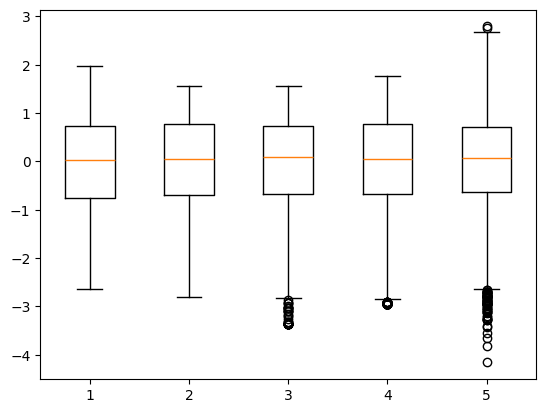

In [10]:
# Normalize numeric dataset
scaler = StandardScaler()
standardized_data = scaler.fit_transform(numeric_df)

plt.boxplot(standardized_data)
plt.show()

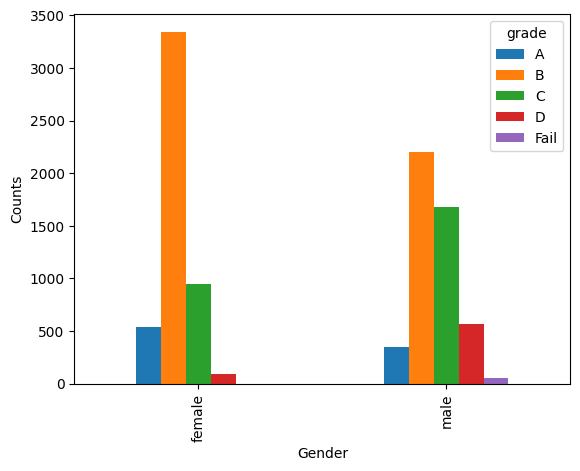

In [13]:
# Group by the 'Month' and Sub-group by Revenue
grouped_data = student_data.groupby(['gender'])['grade'].value_counts().unstack()
grouped_df = grouped_data.reset_index() # Converts result to DF

grouped_df.plot(x='gender', kind='bar')
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.show()

In [ ]:
for col_name in student_data.columns:
    print(col_name, student_data[col_name].unique())